**Chapter 6 – Decision Trees**

_This notebook contains all the sample code and solutions to the exercises in chapter 6._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml/blob/master/06_decision_trees.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

**Warning**: this is the code for the 1st edition of the book. Please visit https://github.com/ageron/handson-ml2 for the 2nd edition code, with up-to-date notebooks using the latest library versions.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Training and visualizing

criterion：
特征选择标准，【entropy, gini】。默认gini，即CART算法。

splitter：
特征划分标准，【best, random】。best在特征的所有划分点中找出最优的划分点，random随机的在部分划分点中找局部最优的划分点。默认的‘best’适合样本量不大的时候，而如果样本数据量非常大，此时决策树构建推荐‘random’。

max_depth：
决策树最大深度，【int,  None】。默认值是‘None’。一般数据比较少或者特征少的时候可以不用管这个值，如果模型样本数量多，特征也多时，推荐限制这个最大深度，具体取值取决于数据的分布。常用的可以取值10-100之间，常用来解决过拟合。

min_samples_split：
内部节点（即判断条件）再划分所需最小样本数，【int, float】。默认值为2。如果是int，则取传入值本身作为最小样本数；如果是float，则取ceil(min_samples_split*样本数量)作为最小样本数。（向上取整）

min_samples_leaf：
叶子节点（即分类）最少样本数。如果是int，则取传入值本身作为最小样本数；如果是float，则取ceil(min_samples_leaf*样本数量)的值作为最小样本数。这个值限制了叶子节点最少的样本数，如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝。

min_weight_fraction_leaf：
叶子节点（即分类）最小的样本权重和，【float】。这个值限制了叶子节点所有样本权重和的最小值，如果小于这个值，则会和兄弟节点一起被剪枝。默认是0，就是不考虑权重问题，所有样本的权重相同。

一般来说如果我们有较多样本有缺失值或者分类树样本的分布类别偏差很大，就会引入样本权重，这时就要注意此值。

max_features：
在划分数据集时考虑的最多的特征值数量，【int值】。在每次split时最大特征数；【float值】表示百分数，即（max_features*n_features）

random_state：
【int, randomSate instance, None】，默认是None

max_leaf_nodes：
最大叶子节点数。【int, None】，通过设置最大叶子节点数，可以防止过拟合。默认值None，默认情况下不设置最大叶子节点数。如果加了限制，算法会建立在最大叶子节点数内最优的决策树。如果特征不多，可以不考虑这个值，但是如果特征多，可以加限制，具体的值可以通过交叉验证得到。

min_impurity_decrease：
节点划分最小不纯度，【float】。默认值为‘0’。限制决策树的增长，节点的不纯度（基尼系数，信息增益，均方差，绝对差）必须大于这个阈值，否则该节点不再生成子节点。

min_impurity_split（已弃用）：
信息增益的阀值。决策树在创建分支时，信息增益必须大于这个阈值，否则不分裂。（从版本0.19开始不推荐使用：min_impurity_split已被弃用，以0.19版本中的min_impurity_decrease取代。 min_impurity_split的默认值将在0.23版本中从1e-7变为0，并且将在0.25版本中删除。 请改用min_impurity_decrease。）

class_weight：
类别权重，【dict, list of dicts, balanced】，默认为None。（不适用于回归树，sklearn.tree.DecisionTreeRegressor）

指定样本各类别的权重，主要是为了防止训练集某些类别的样本过多，导致训练的决策树过于偏向这些类别。balanced，算法自己计算权重，样本量少的类别所对应的样本权重会更高。如果样本类别分布没有明显的偏倚，则可以不管这个参数。

presort：
bool，默认是False，表示在进行拟合之前，是否预分数据来加快树的构建。

对于数据集非常庞大的分类，presort=true将导致整个分类变得缓慢；当数据集较小，且树的深度有限制，presort=true才会加速分类。


In [4]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
# 决策树

# 加载数据
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

# 决策树
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

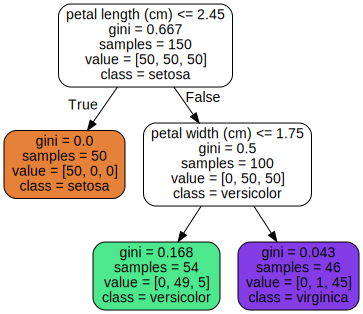

In [28]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
# 决策树可视化

def image_path(fig_id):
    return os.path.join(IMAGES_PATH, fig_id)

# export_graphviz(
#         tree_clf,
#         out_file=image_path("iris_tree.dot"),
#         feature_names=iris.feature_names[2:],
#         class_names=iris.target_names,
#         rounded=True,
#         filled=True
#     )
graph = Source(export_graphviz(
        tree_clf,
        out_file=None,
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    ))
display(SVG(graph.pipe(format='svg')))

Saving figure decision_tree_decision_boundaries_plot


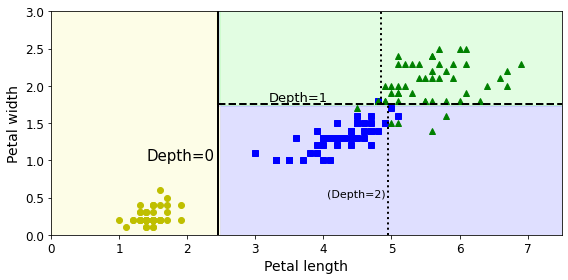

In [8]:
from matplotlib.colors import ListedColormap
"""
class matplotlib.colors.ListedColormap(colors, name=’from_list’, N=None)
matplotlib.colors模块用于将颜色或数字参数转换为RGBA或RGB。
此模块用于将数字映射到颜色或以一维颜色数组(也称为colormap)进行颜色规格转换。
"""
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
#     数据
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
#     预测
    y_pred = clf.predict(X_new).reshape(x1.shape)
#     等高线图
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
#         绘制训练数据
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
# 绘制决策边界
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

# Predicting classes and class probabilities

In [10]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [11]:
tree_clf.predict([[5, 1.5]])

array([1])

信息熵
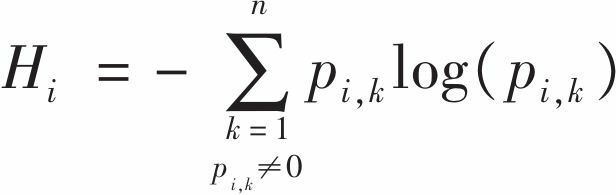
基尼不纯度
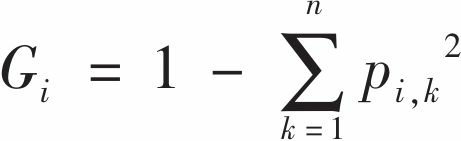
CART分类成本函数
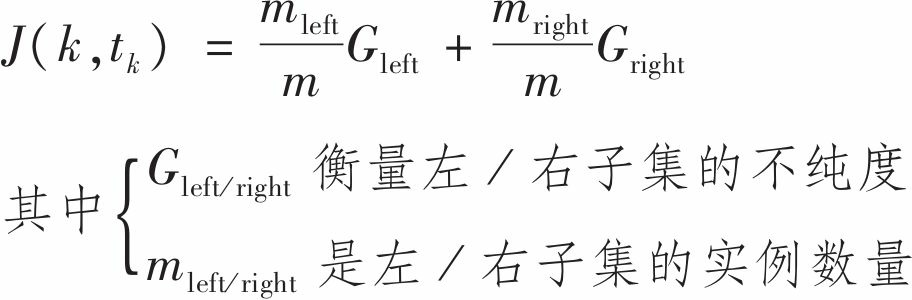
那么你到底应该使用基尼不纯度还是信息熵呢？ 其实， 大多数情
况下， 它们并没有什么大的不同， 产生的树都很相似。 基尼不纯度的
计算速度略微快一些， 所以它是个不错的默认选择。 它们的不同在
于， 基尼不纯度倾向于从树枝中分裂出最常见的类别， 而信息熵则倾
向于生产更平衡的树。 

# Sensitivity to training set details

In [7]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y 1)] # widest Iris-Versicolor flower

array([[4.8, 1.8]])

In [13]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

# 减小max_depth可使模型正则化，从而降低过度拟合的风险。
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(max_depth=2, random_state=40)

Saving figure decision_tree_instability_plot


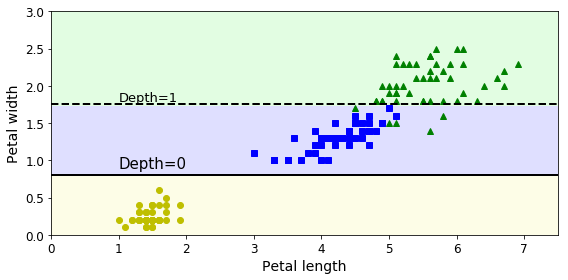

In [9]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

DecisionTreeClassifier类还有一些其他的参数，同样可以限制决策树的形状：

min_samples_split（分裂前节点必须有的最小样本数）， 

min_samples_leaf（叶节点必须有的最小样本数量），

min_weight_fraction_leaf（跟min_samples_leaf一样，但表现为加权实例总数的占比）， 

max_leaf_nodes（最大叶节点数量），以及

max_features（分裂每个节点评估的最大特征数量）。

增大超参数min_*或是减小max_*将使模型正则化

Saving figure min_samples_leaf_plot


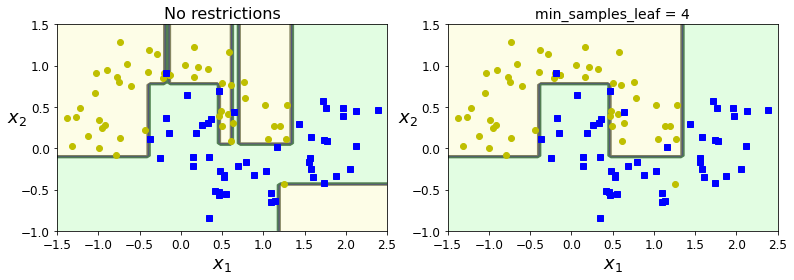

In [14]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

# 设置min_samples_leaf使模型正则化
deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

save_fig("min_samples_leaf_plot")
plt.show()

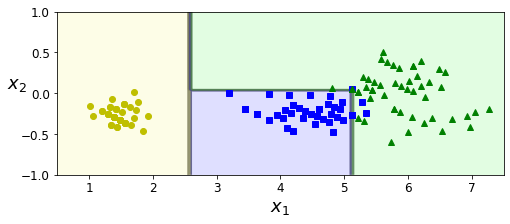

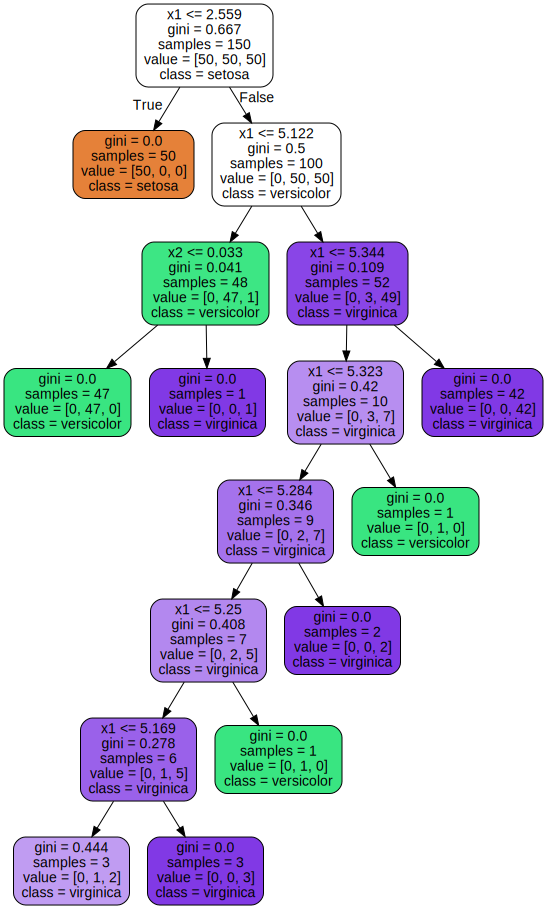

In [38]:
# 将数据旋转
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

graph = Source(export_graphviz(
        tree_clf_r,
        out_file=None,
        feature_names=['x1','x2'],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    ))
display(SVG(graph.pipe(format='svg')))

Saving figure sensitivity_to_rotation_plot


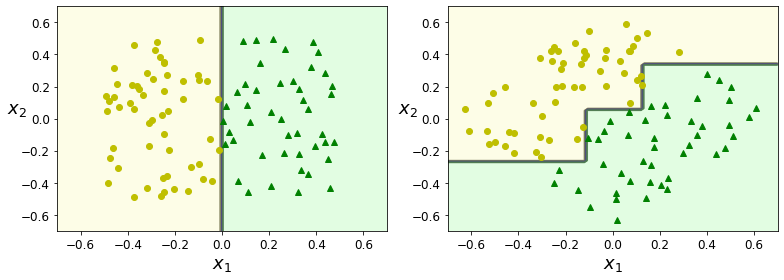

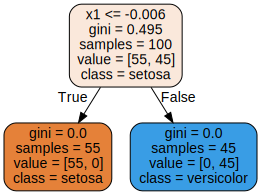

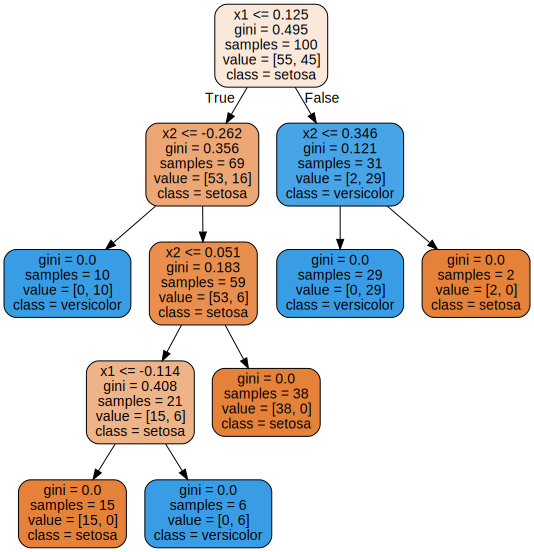

In [39]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
save_fig("sensitivity_to_rotation_plot")
plt.show()

graph = Source(export_graphviz(
        tree_clf_s,
        out_file=None,
        feature_names=['x1','x2'],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    ))
display(SVG(graph.pipe(format='svg')))

graph = Source(export_graphviz(
        tree_clf_sr,
        out_file=None,
        feature_names=['x1','x2'],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    ))
display(SVG(graph.pipe(format='svg')))


# Regression trees

In [45]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [46]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

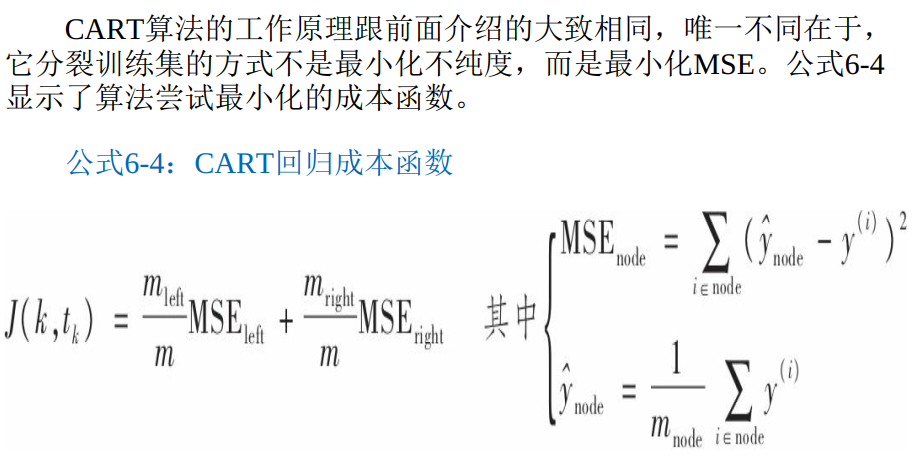

Saving figure tree_regression_plot


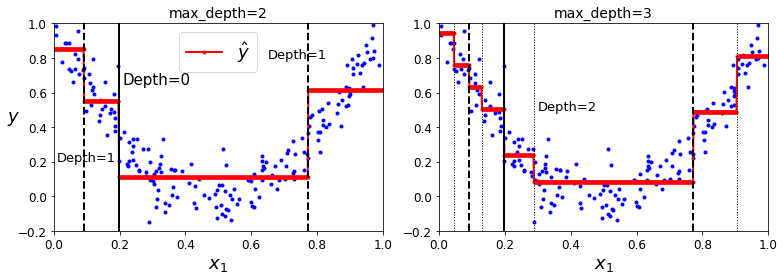

In [53]:
from sklearn.tree import DecisionTreeRegressor
# 每个区域的预测值永远等于该区域内实例的目标平均值

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

# graph = Source(export_graphviz(
#         tree_reg1,
#         out_file=None,
#         feature_names=['x'],
#         class_names=iris.target_names,
#         rounded=True,
#         filled=True
#     ))
# display(SVG(graph.pipe(format='svg')))

# graph = Source(export_graphviz(
#         tree_reg2,
#         out_file=None,
#         feature_names=['x'],
#         class_names=iris.target_names,
#         rounded=True,
#         filled=True
#     ))
# display(SVG(graph.pipe(format='svg')))

In [54]:
export_graphviz(
        tree_reg1,
        out_file=image_path("regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

Saving figure tree_regression_regularization_plot


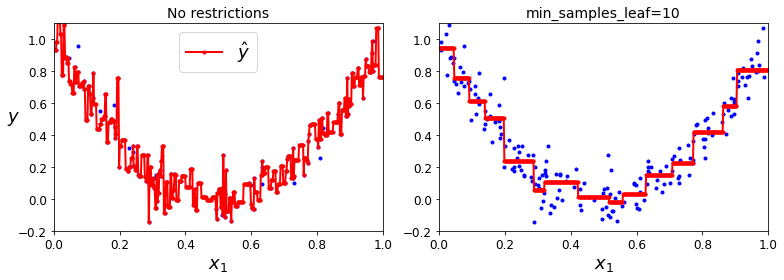

In [55]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

# Exercise solutions

## 1. to 6.

See appendix A.

## 7.

_Exercise: train and fine-tune a Decision Tree for the moons dataset._

a. Generate a moons dataset using `make_moons(n_samples=10000, noise=0.4)`.

Adding `random_state=42` to make this notebook's output constant:

In [62]:
from sklearn.datasets import make_moons
# 使用make_moons（n_samples=10000， noise=0.4） 生成一个卫星数据集。
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

b. Split it into a training set and a test set using `train_test_split()`.

In [63]:
from sklearn.model_selection import train_test_split
# 使用train_test_split（） 拆分训练集和测试集。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

c. Use grid search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.

In [65]:
from sklearn.model_selection import GridSearchCV
# 使用交叉验证的网格搜索（在GridSearchCV的帮助下） 为DecisionTree-Classifier找到适合的超参数。 
# 提示： 尝试max_leaf_nodes的多种值。

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [66]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

d. Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly 85% to 87% accuracy.

By default, `GridSearchCV` trains the best model found on the whole training set (you can change this by setting `refit=False`), so we don't need to do it again. We can simply evaluate the model's accuracy:

In [67]:
from sklearn.metrics import accuracy_score
# 使用超参数对整个训练集进行训练， 并测量模型在测试集上的性能。 你应该得到约85%到87%的准确率。

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

## 8.

_Exercise: Grow a forest._

a. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn's `ShuffleSplit` class for this.

In [68]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

"""
sklearn.model_selection.ShuffleSplit类用于将样本集合随机“打散”后划分为训练集、测试集
参数：
n_splits:int, 划分训练集、测试集的次数，默认为10
test_size:float, int, None, default=0.1； 测试集比例或样本数量，该值为[0.0, 1.0]内的浮点数时，
    表示测试集占总样本的比例；该值为整型值时，表示具体的测试集样本数量；
    train_size不设定具体数值时，该值取默认值0.1，train_size设定具体数值时，test_size取剩余部分
train_size:float, int, None； 训练集比例或样本数量，该值为[0.0, 1.0]内的浮点数时，表示训练集占总样本的比例；
    该值为整型值时，表示具体的训练集样本数量；该值为None(默认值)时，训练集取总体样本除去测试集的部分
random_state:int, RandomState instance or None；随机种子值，默认为None
"""

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

b. Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

In [69]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's `mode()` function for this). This gives you _majority-vote predictions_ over the test set.

In [70]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [71]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest classifier!

In [72]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872